### Multi-Label Classification with an Enzyme Substrate Dataset


**Goal**: The goal of this project is to build machine learning models that can accurately predict the enzyme classification of proteins under the first two Enzyme Commission categories (EC1 and EC2) using the six provided input features. By focusing on these two categories, the project aims to demonstrate how computational methods can assist in functional annotation of enzymes, reducing the time and cost of manual biochemical experiments.

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the training dataset
train = pd.read_csv('train.csv')
train.head()

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
0,0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,...,4.794537,35.527357,0,0,1,1,0,0,0,0
1,1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,...,13.825658,44.707310,0,0,0,1,1,0,0,0
2,2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,...,17.964475,45.660120,0,0,1,1,0,0,1,0
3,3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,...,31.961948,87.509997,0,0,1,1,0,0,0,0
4,4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,...,9.589074,33.333333,2,2,1,0,1,1,1,0


#### Dataset Description

The dataset used in this project is from the **Multi-Label Classification of Enzyme Substrates** competition. It consists of molecular descriptors and targets for enzyme classification. The goal of this project is to predict **EC1** and **EC2** using these features.

##### Columns

**Features (X):**

- `BertzCT` : Molecular complexity descriptor based on graph theory.  
- `Chi1`, `Chi1n`, `Chi1v`, `Chi2n`, `Chi2v`, `Chi3v`, `Chi4n` : Molecular connectivity indices (Chi descriptors).  
- `EState_VSA1`, `EState_VSA2` : Electrotopological state descriptors combined with van der Waals surface area.  
- `ExactMolWt` : Exact molecular weight of the compound.  
- `FpDensityMorgan1`, `FpDensityMorgan2`, `FpDensityMorgan3` : Morgan fingerprint densities (topological descriptors).  
- `HallKierAlpha` : Molecular shape index descriptor.  
- `HeavyAtomMolWt` : Molecular weight considering only heavy atoms.  
- `Kappa3` : Molecular shape index (third order).  
- `MaxAbsEStateIndex`, `MinEStateIndex` : Maximum and minimum electrotopological state indices.  
- `NumHeteroatoms` : Number of heteroatoms in the molecule.  
- `PEOE_VSA6`, `PEOE_VSA7`, `PEOE_VSA8`, `PEOE_VSA10`, `PEOE_VSA14` : Partial charge descriptors combined with van der Waals surface area.  
- `SMR_VSA5`, `SMR_VSA10` : Molar refractivity descriptors combined with van der Waals surface area.  
- `SlogP_VSA3` : Lipophilicity (LogP) combined with van der Waals surface area.  
- `VSA_EState9` : Electrotopological state descriptor combined with van der Waals surface area.  
- `fr_COO`, `fr_COO2` : Count of specific functional groups (carboxylic acids).  

**Targets (y):**

- `EC1` : First level enzyme classification (binary).  
- `EC2` : Second level enzyme classification (binary).  
- `EC3`–`EC6` : Additional enzyme classification levels (binary, not used in this project).  
  



In [3]:
#loading the test dataset
test = pd.read_csv('test.csv')
test.head()

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,14838,344.632371,7.283603,4.473966,5.834958,3.412257,4.651530,2.096558,1.116433,49.458581,...,13.512441,0.000000,0.000000,0.000000,26.809272,24.539800,4.794537,47.304082,1,1
1,14839,1432.410201,10.663869,7.079026,8.065215,5.297097,5.297097,3.924155,2.569694,0.000000,...,0.000000,34.947374,98.323987,9.606882,0.000000,53.378235,0.000000,43.166667,0,0
2,14840,83.352608,3.931852,1.774215,1.774215,1.073446,1.073446,0.467830,0.170838,5.969305,...,5.969305,0.000000,0.000000,6.420822,11.752550,13.344559,9.589074,24.666667,1,1
3,14841,150.255712,5.912790,3.548812,3.548812,2.595128,2.595128,1.642813,0.694113,0.000000,...,59.935299,0.000000,0.000000,0.000000,17.744066,32.290168,4.794537,26.778866,0,0
4,14842,1817.276351,24.910940,15.540529,20.047314,12.535886,17.730988,11.979618,4.431173,84.554972,...,23.468091,25.609359,0.000000,37.099000,69.141353,38.704130,50.697492,102.583333,0,0


<b>Data Understanding</b>

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14838 entries, 0 to 14837
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 14838 non-null  int64  
 1   BertzCT            14838 non-null  float64
 2   Chi1               14838 non-null  float64
 3   Chi1n              14838 non-null  float64
 4   Chi1v              14838 non-null  float64
 5   Chi2n              14838 non-null  float64
 6   Chi2v              14838 non-null  float64
 7   Chi3v              14838 non-null  float64
 8   Chi4n              14838 non-null  float64
 9   EState_VSA1        14838 non-null  float64
 10  EState_VSA2        14838 non-null  float64
 11  ExactMolWt         14838 non-null  float64
 12  FpDensityMorgan1   14838 non-null  float64
 13  FpDensityMorgan2   14838 non-null  float64
 14  FpDensityMorgan3   14838 non-null  float64
 15  HallKierAlpha      14838 non-null  float64
 16  HeavyAtomMolWt     148

In [5]:
train.describe()

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
count,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,...,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000
mean,7418.500000,515.153604,9.135189,5.854307,6.738497,4.432570,5.253221,3.418749,1.773472,29.202823,...,13.636941,49.309959,0.458215,0.459226,0.667745,0.798962,0.313789,0.279081,0.144831,0.151570
std,4283.505982,542.456370,6.819989,4.647064,5.866444,3.760516,4.925065,3.436208,1.865898,31.728679,...,14.598554,29.174824,0.667948,0.668111,0.471038,0.400790,0.464047,0.448562,0.351942,0.358616
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-5.430556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3709.250000,149.103601,4.680739,2.844556,2.932842,1.949719,2.034468,1.160763,0.503897,5.969305,...,4.794537,30.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,7418.500000,290.987941,6.485270,4.052701,4.392859,2.970427,3.242775,1.948613,1.073261,17.353601,...,9.589074,41.666667,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,11127.750000,652.652585,11.170477,7.486791,8.527859,5.788793,6.609350,4.502070,2.534281,44.876559,...,14.912664,56.090650,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,14837.000000,4069.959780,69.551167,50.174588,53.431954,32.195368,34.579313,22.880836,16.072810,363.705954,...,115.406157,384.450519,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
#check for nulls on the training set
train.isnull().sum()

id                   0
BertzCT              0
Chi1                 0
Chi1n                0
Chi1v                0
Chi2n                0
Chi2v                0
Chi3v                0
Chi4n                0
EState_VSA1          0
EState_VSA2          0
ExactMolWt           0
FpDensityMorgan1     0
FpDensityMorgan2     0
FpDensityMorgan3     0
HallKierAlpha        0
HeavyAtomMolWt       0
Kappa3               0
MaxAbsEStateIndex    0
MinEStateIndex       0
NumHeteroatoms       0
PEOE_VSA10           0
PEOE_VSA14           0
PEOE_VSA6            0
PEOE_VSA7            0
PEOE_VSA8            0
SMR_VSA10            0
SMR_VSA5             0
SlogP_VSA3           0
VSA_EState9          0
fr_COO               0
fr_COO2              0
EC1                  0
EC2                  0
EC3                  0
EC4                  0
EC5                  0
EC6                  0
dtype: int64

there were no nulls for the training data set

In [7]:
#checking for the nulls in the test set
test.isnull().sum()

id                   0
BertzCT              0
Chi1                 0
Chi1n                0
Chi1v                0
Chi2n                0
Chi2v                0
Chi3v                0
Chi4n                0
EState_VSA1          0
EState_VSA2          0
ExactMolWt           0
FpDensityMorgan1     0
FpDensityMorgan2     0
FpDensityMorgan3     0
HallKierAlpha        0
HeavyAtomMolWt       0
Kappa3               0
MaxAbsEStateIndex    0
MinEStateIndex       0
NumHeteroatoms       0
PEOE_VSA10           0
PEOE_VSA14           0
PEOE_VSA6            0
PEOE_VSA7            0
PEOE_VSA8            0
SMR_VSA10            0
SMR_VSA5             0
SlogP_VSA3           0
VSA_EState9          0
fr_COO               0
fr_COO2              0
dtype: int64

There were no nulls for the test set

<b>Explanatory Data Analysis</b>

Target (EC Classes) Distribution

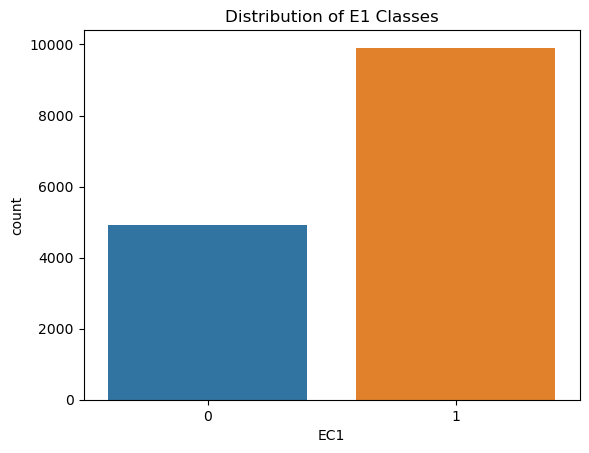

In [8]:
#target (E1 Classes) distribution
sns.countplot(x='EC1', data=train)
plt.title('Distribution of E1 Classes') 
plt.show()

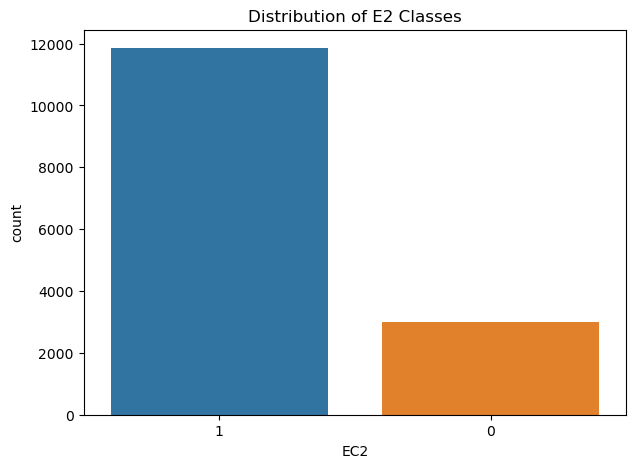

In [9]:
#target (E2 Classes) distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='EC2', data=train, order=train['EC2'].value_counts().index)
plt.title('Distribution of E2 Classes') 
plt.show()

Correlation between features

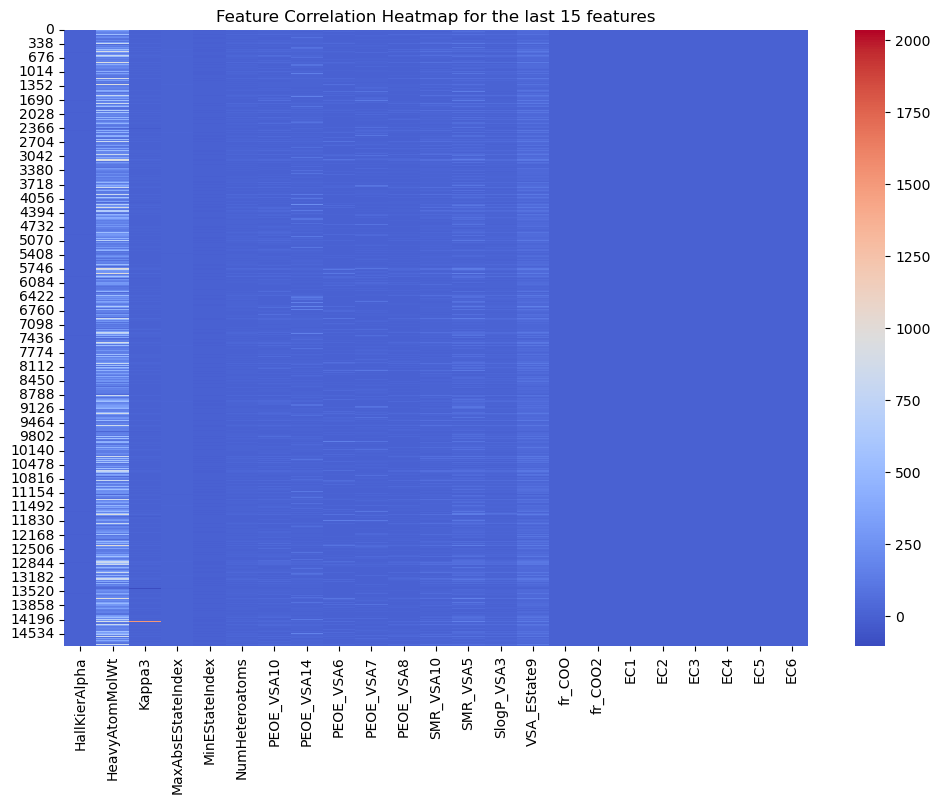

In [10]:
sample_features = train .select_dtypes(include=['float64', 'int64']).iloc[:, 15:]

plt.figure(figsize=(12,8))
sns.heatmap(sample_features, cmap="coolwarm", annot=False)
plt.title('Feature Correlation Heatmap for the last 15 features')
plt.show()

Feature Distribution

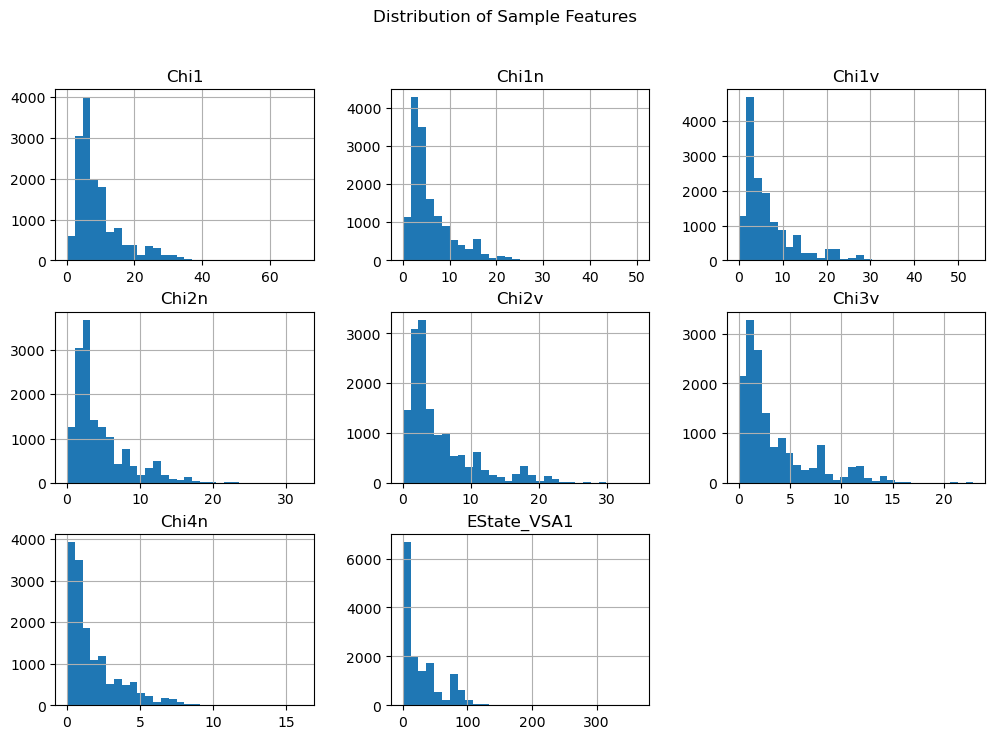

In [11]:
# histogram for first few numeric features
train.iloc[:, 2:10].hist(figsize=(12,8), bins=30)
plt.suptitle("Distribution of Sample Features")
plt.show()


In [12]:
print(train['EC1'].value_counts(normalize=True))

print(train['EC2'].value_counts(normalize=True))


EC1
1    0.667745
0    0.332255
Name: proportion, dtype: float64
EC2
1    0.798962
0    0.201038
Name: proportion, dtype: float64


<b>Modelling</b>

Train-test split

In [ ]:
X = train.drop(['EC1','EC2'], axis=1)
y1 = train['EC1'] # Target variable for EC1 classification
y2 = train['EC2'] # Target variable for EC2 classification


In [ ]:
def run_models(X, y, test_size=0.2, random_state=42):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print("Class distribution in training data:\n", y_train.value_counts())
    print("\n")
    
    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train, y_train)
    y_pred_lr = logreg.predict(X_test)
    print("=== Logistic Regression ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_lr))
    print(classification_report(y_test, y_pred_lr))
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=120,random_state=random_state)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print("=== Random Forest ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_rf))
    print(classification_report(y_test, y_pred_rf))
    
    return logreg, rf

# EC1
log_model1, rf_model1 = run_models(X, y1)

# EC2
log_model2, rf_model2 = run_models(X, y2)


Class distribution in training data:
 EC1
1    7916
0    3954
Name: count, dtype: int64


=== Logistic Regression ===
Accuracy: 0.7129380053908356
              precision    recall  f1-score   support

           0       0.61      0.36      0.46       976
           1       0.74      0.88      0.81      1992

    accuracy                           0.71      2968
   macro avg       0.67      0.62      0.63      2968
weighted avg       0.70      0.71      0.69      2968

=== Random Forest ===
Accuracy: 0.7617924528301887
              precision    recall  f1-score   support

           0       0.67      0.54      0.60       976
           1       0.79      0.87      0.83      1992

    accuracy                           0.76      2968
   macro avg       0.73      0.70      0.71      2968
weighted avg       0.75      0.76      0.75      2968

Class distribution in training data:
 EC2
1    9455
0    2415
Name: count, dtype: int64


=== Logistic Regression ===
Accuracy: 0.8049191374663073
 

In [21]:
def run_models(X, y, test_size=0.2, random_state=42):
    """
    Trains Logistic Regression and Random Forest on the dataset with scaling + SMOTE,
    then prints classification reports and accuracy scores.
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Scale features 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply SMOTE to the scaled training data
    sm = SMOTE(random_state=random_state)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)
    
    print("Before SMOTE class distribution:\n", y_train.value_counts())
    print("After SMOTE class distribution:\n", y_resampled.value_counts())
    print("\n")
    
    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_resampled, y_resampled)
    y_pred_lr = logreg.predict(X_test_scaled)
    print("=== Logistic Regression ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_lr))
    print(classification_report(y_test, y_pred_lr))
    
    # Random Forest
    rf = RandomForestClassifier(random_state=random_state)
    rf.fit(X_resampled, y_resampled)
    y_pred_rf = rf.predict(X_test_scaled)
    print("=== Random Forest ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_rf))
    print(classification_report(y_test, y_pred_rf))
    
    return logreg, rf

# Run for EC1
log_model1, rf_model1 = run_models(X, y1)

# Run for EC2
log_model2, rf_model2 = run_models(X, y2)


Before SMOTE class distribution:
 EC1
1    7916
0    3954
Name: count, dtype: int64
After SMOTE class distribution:
 EC1
1    7916
0    7916
Name: count, dtype: int64


=== Logistic Regression ===
Accuracy: 0.7216981132075472
              precision    recall  f1-score   support

           0       0.56      0.75      0.64       976
           1       0.85      0.71      0.77      1992

    accuracy                           0.72      2968
   macro avg       0.70      0.73      0.71      2968
weighted avg       0.76      0.72      0.73      2968

=== Random Forest ===
Accuracy: 0.7597708894878706
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       976
           1       0.83      0.81      0.82      1992

    accuracy                           0.76      2968
   macro avg       0.73      0.73      0.73      2968
weighted avg       0.76      0.76      0.76      2968

Before SMOTE class distribution:
 EC2
1    9455
0    2415
Name: count